# Plan2Scene: Converting Floorplans to 3D Scenes
Madhawa Vidanapathirana, Qirui Wu, Yasutaka Furukawa, Angel X. Chang , Manolis Savva

Simon Fraser University

*CVPR 2021*


[[Project Page](https://3dlg-hcvc.github.io/plan2scene/), [GitHub](https://github.com/3dlg-hcvc/plan2scene), [Paper](https://arxiv.org/abs/2106.05375)]

<img src='https://raw.githubusercontent.com/3dlg-hcvc/plan2scene/main/docs/img/intro.png' height='300'/>

Our system addresses the Plan2Scene task by converting a floorplan and set of photos into a textured 3D mesh model.


## Plan2Scene Stages
<img src='https://raw.githubusercontent.com/3dlg-hcvc/plan2scene/main/docs/img/task-overview.png'/>

The Plan2Scene task consists of several steps: floorplan vectorization, 3D geometry construction, object placement, photo assignment, texture generation, and texture propagation.

This notebook focuses on the texture generation and the texture propagation steps of the task. We assume a vectorized floorplan is available, and the photos are assigned to rooms.

## Pre-requisites
1. __Run this notebook using a GPU runtime.__

2. You are required to upload a **floorplan vector of a house** (in scene.json format), **extracted rectified surface crops**, and **photo room assignments** to use this notebook. You can refer to our dataset [Rent3D++](https://3dlg-hcvc.github.io/plan2scene/) for the above information.

3. To preview the final textured 3D house, you have to use [smart scene toolkit](https://github.com/smartscenes/sstk) scene viewer in your local machine. This notebook allows previewing of synthesized textures as individual images, but not as a 3D model.

In [2]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [4]:
# Download the code
!git clone https://github.com/3dlg-hcvc/plan2scene.git

fatal: destination path 'plan2scene' already exists and is not an empty directory.


## Setup environment

In [5]:
# Install torch
# !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidi

In [7]:
# Install requirements
!pip install numpy pandas pyyaml orderedattrdict kornia>=0.2.0 tensorboard git+https://github.com/sbrisard/moisan2011.git@master pytorch-fid>=0.1.1

  Running command git clone --filter=blob:none --quiet https://github.com/sbrisard/moisan2011.git /tmp/pip-req-build-qro04muq


In [8]:
# Install PyTorch Geometric
# %env CUDA=cu110
%env CUDA=cu12.4
# %env TORCH=1.7.1
%env TORCH=2.6.0
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html --no-cache
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html --no-cache # This step takes unusually long. About 30 minutes.
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html --no-cache
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html --no-cache
!pip install torch-geometric --no-cache

env: CUDA=cu12.4
env: TORCH=2.6.0
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu12.4.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=3622721 sha256=b9c7db8d284744ffddd8682597ea39274a87d5551672d0cd8100c6bbea814bbf
  Stored in directory: /tmp/pip-ephem-wheel-cache-ybgeways/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
Successfully built torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu12.4.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=2846205 sha256=da3774942b86d3f2bb13cb327cdf8b608f1a38a91b38b3ef47be22cc2f088c3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-xxfv8_

In [ ]:
# Install noise kernel
%cd ./plan2scene
%cd code/src/plan2scene/texture_gen/custom_ops/noise_kernel
!pip install .
%cd ../../../../../../../

In [ ]:
# Download EmbarkStudios Texture Synthesis library. We use it to correct seams of textures so they can be tiled.
%env EMBARK_TEX_SYNTH=texture-synthesis-0.8.2-x86_64-unknown-linux-musl
!wget https://github.com/EmbarkStudios/texture-synthesis/releases/download/0.8.2/$EMBARK_TEX_SYNTH.tar.gz
!tar -xf $EMBARK_TEX_SYNTH.tar.gz

# Download seam mask
!wget -P $EMBARK_TEX_SYNTH https://raw.githubusercontent.com/EmbarkStudios/texture-synthesis/main/imgs/masks/1_tile.jpg

In [ ]:
# Specify seam correction configuration
import os
import os.path as osp
import json
texture_synthesis_conf = {
    "texture_synthesis_path": osp.abspath(osp.join(os.environ["EMBARK_TEX_SYNTH"], "texture-synthesis")),
    "seam_mask_path": osp.abspath(osp.join(os.environ["EMBARK_TEX_SYNTH"], "1_tile.jpg"))
}
with open("./plan2scene/conf/plan2scene/seam_correct.json", "w") as f:
  json.dump(texture_synthesis_conf, f, indent=4)

assert osp.exists(texture_synthesis_conf["texture_synthesis_path"])
assert osp.exists(texture_synthesis_conf["seam_mask_path"])

## Load Plan2Scene Modules
__Re-run from here if you restart the runtime.__

In [ ]:
%cd ./plan2scene

In [1]:
# Load system modules
import zipfile
import io
import os.path as osp
import os
# from google.colab import files
import json
import pandas as pd
import sys
from IPython.display import display, HTML
from ipywidgets import interact
from PIL import ImageDraw, Image
import torch

# Load Plan2Scene modules
sys.path.append("./code/src")
from arch_parser.parser import parse_arch_json, parse_object_jsons, PreferredFormat, parse_scene_json_from_file
from plan2scene.common.residence import House
from plan2scene.config_manager import ConfigManager
from plan2scene.common.image_description import ImageDescription, ImageSource
from plan2scene.utils.io import load_image
from arch_parser.json_util import pil_to_data_url
from plan2scene.texture_gen.predictor import TextureGenPredictor
from plan2scene.texture_gen.utils.io import load_conf_eval
from plan2scene.crop_select.util import fill_textures
from plan2scene.texture_prop.utils import update_embeddings
from plan2scene.texture_prop.predictor import TexturePropPredictor
from plan2scene.texture_prop.graph_generators import InferenceHGG
from plan2scene.texture_prop.houses_dataset import HouseDataset
from torch_geometric.data import DataLoader
from plan2scene.common.house_parser import save_arch
from plan2scene.utils.tile_util import tile_image

# Initialize config manager
conf = ConfigManager()
conf.load_default_args()
conf.texture_gen.texture_synth_conf = "./conf/plan2scene/texture_synth_conf/v2.yml"

INFO:root:Using seed: 12415
INFO:root:Args: Namespace(seed=12415, data_paths='./conf/plan2scene/data_paths.json', house_gen='./conf/plan2scene/house_gen.json', metric_conf='./conf/plan2scene/metric.json', texture_gen='./conf/plan2scene/texture_gen.json', texture_prop='./conf/plan2scene/texture_prop_conf/default.json', render_config='./conf/plan2scene/render.json', seam_correct_config='./conf/plan2scene/seam_correct.json', labels_path='./conf/plan2scene/labels', log_level='INFO', drop='0.0', num_workers=4)


In [ ]:
def upload():
  """
  Utility method for file uploads.
  """
  uploaded = files.upload()
  assert len(uploaded) == 1
  content = None
  for key in uploaded.keys():
    print('Uploaded file "{name}" with length {length} bytes'.format(
        name=key, length=len(uploaded[key])))
    return uploaded[key]

In [2]:
def load_json_as_str(path, encoding="utf-8"):
    """
    Read a JSON file from disk and return its contents as a string.
    """
    with open(path, "rb") as f:
        data = f.read()
    return data.decode(encoding)

## Data
In this section, we will obtain the following files from you.
1. A floorplan vector in the scene.json format. Refer to the Rent3D++ dataset for examples. The scene.json format is [explained here](https://github.com/3dlg-hcvc/plan2scene/blob/main/docs/md/scene_json_format.md).
2. Rectified surface crops extracted from photos of the house.
  - If you wish to extract new rectified surface crops, [refer to instructions here](https://github.com/3dlg-hcvc/plan2scene/blob/main/docs/md/extract_crops.md).
  - Otherwise, you can provide rectified surface crops provided with the Rent3D++ dataset.
3. Photo room assignments specified in a photoroom.csv file. Refer to the Rent3D++ dataset for examples. The format of the photoroom.csv file is [described here](https://github.com/3dlg-hcvc/plan2scene/blob/main/docs/md/rent3dpp_data_organization.md).

__Task:__ Upload a scene.json file describing a floorplan vector.

Sketch of floorplan vector.


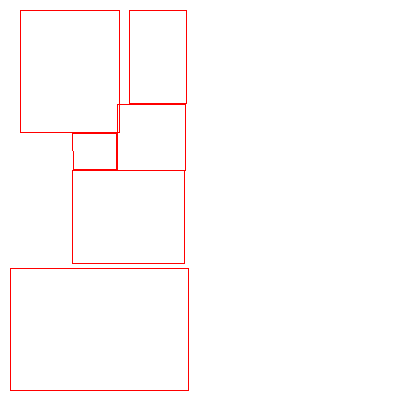

In [4]:
house_key = None
if not osp.exists("./data/processed/archs"):
  os.makedirs("./data/processed/archs")

# scene_json_content = upload()
scene_json_path = "/home/hyunkoo/DATA/HDD8TB/Project/plan2scene/data/processed/archs_with_hole_models/test/28025487.scene.json"
# scene_json = json.loads(scene_json_content.decode())
scene_json_content_decode = load_json_as_str(scene_json_path)
# scene_json = json.loads(scene_json_content.decode())
scene_json = json.loads(scene_json_content_decode)
scene_id = scene_json["scene"]["arch"]["id"]

with open(f"./data/processed/archs/{scene_id}.scene.json", "w") as f:
  # f.write(scene_json_content.decode())
  f.write(scene_json_content_decode)

print("Sketch of floorplan vector.")
arch_house = parse_scene_json_from_file(f"./data/processed/archs/{scene_id}.scene.json",  None)
arch_house.sketch_house()

__Task:__ Upload rectified surface crops extracted from photos.

The rectified surface crops should be named in the format '[photo_file_name_without_extension]_[surface_id]_crop[crop_id].png'. The rectified surface crops provided with the Rent3D++ dataset are in this format. If you extract new rectified surface crops using the code we provide, they will also be in this format.

When you run the next cell, you will be prompted to upload 3 zip files, one per surface type, containing crops sampled from rectified surfaces.

For the Rent3D++ dataset, you can create such zip files using the rectified crops available in the './processed/rectified_crops/[surface_type]' directories provided by the Rent3D++ dataset. Note that each photo of the Rent3D++ dataset has a filename starting with the house_key. So, you can search and identify the crops belonging to the scene.json file you uploaded before.

In [ ]:
for surface in conf.surfaces:
  print(f"Please provide a .zip file containing rectified crops extracted from {surface} surfaces.")

  if not osp.exists(f"./data/processed/rectified_crops/{surface}"):
    os.makedirs(f"./data/processed/rectified_crops/{surface}")

  crops_content = upload()
  zf = zipfile.ZipFile(io.BytesIO(crops_content), "r")
  zf.extractall(path=f"./data/processed/rectified_crops/{surface}")
  print()

__Task:__ Upload a photoroom.csv file describing the assignment of photos to rooms.

In [ ]:
photoroom_content = upload()

os.makedirs("./data/processed/photo_assignments", exist_ok=True)

photo_room_df = pd.read_csv(io.BytesIO(photoroom_content))
assert "roomId" in photo_room_df.columns
assert "photo" in photo_room_df.columns
photo_room_df.to_csv(f"./data/processed/photo_assignments/{scene_id}.photoroom.csv")
photo_room_df

In [ ]:
# Re-load house with crop assignments
arch_house = parse_scene_json_from_file(f"./data/processed/archs/{scene_id}.scene.json", f"./data/processed/photo_assignments/{scene_id}.photoroom.csv")
house = House.from_arch_house(arch_house, surfaces=conf.surfaces)
room_count = len(house.rooms)

for room_index, room in house.rooms.items():
    for photo in room.photos:
        for surface in conf.surfaces:
            surface_instances = [i for i in range(conf.texture_gen.masks_per_surface[surface])]
            for surface_instance in surface_instances:
                for crop_instance in range(conf.texture_gen.crops_per_mask):
                    candidate_key = "%s_%d_crop%d" % (photo, surface_instance, crop_instance)
                    if osp.exists(osp.join(conf.data_paths.rectified_crops_path, surface, candidate_key + ".png")):
                        image = load_image(
                            osp.join(conf.data_paths.rectified_crops_path, surface, candidate_key + ".png"))
                        room.surface_textures[surface][candidate_key] = ImageDescription(image, ImageSource.NEURAL_SYNTH)

__Task:__ Let's preview the data you have provided.

Run the below cell. Then select a room_id from the dropbox to preview crops assigned to a room.

In [ ]:
room_ids = list(house.rooms)

@interact(room_id=room_ids)
def preview_room_crops(room_id):
  room = house.rooms[room_id]

  html_buffer = io.StringIO()
  html_buffer.write("<table>\n")

  for i, surface in enumerate(conf.surfaces):
    html_buffer.write("<tr>\n")
    if i == 0:
      # Left section
      html_buffer.write("<td rowspan='{colspan}'>\n".format( colspan=len(conf.surfaces)))
      html_buffer.write("<img src='{src}'/>\n".format(src=pil_to_data_url(house.sketch_house(focused_room_id=room.room_id))))
      html_buffer.write("<br/>\n")
      html_buffer.write("<p style='text-align:center;'><b>Room Types: </b>{types}</p>\n".format(types=str(room.types)))
      html_buffer.write("</td>\n")

    # Right section
    html_buffer.write("<td>\n")
    html_buffer.write(f"<span>{surface} crops</span>\n")
    html_buffer.write("<br/>\n")
    for crop_id, crop in room.surface_textures[surface].items():
      html_buffer.write("<img src='{src}'/>\n".format(src=pil_to_data_url(crop.image)))
    html_buffer.write("</td>\n")
    html_buffer.write("</tr>\n")

  html_buffer.write("</table>\n")
  display(HTML(html_buffer.getvalue()))

# Synthesize textures for observed surfaces

Download pre-trained weights for the texture synthesis stage. We use the pre-trained model trained on stationary textures dataset version 2.

In [ ]:
%env SYNTH_CHECKPOINT_NAME=loss-7.67493-epoch-750.ckpt
!mkdir ./trained_models/texture_gen/v2/checkpoints
!wget -P ./trained_models/texture_gen/v2/checkpoints http://aspis.cmpt.sfu.ca/projects/plan2scene/pretrained-models/texture-synth/v2/checkpoints/$SYNTH_CHECKPOINT_NAME
conf.texture_gen.checkpoint_path = "./trained_models/texture_gen/v2/checkpoints/{checkpoint_name}".format(checkpoint_name = os.environ["SYNTH_CHECKPOINT_NAME"])

In [ ]:
# Load texture synthesis network
tg_predictor = TextureGenPredictor(
        conf=load_conf_eval(config_path=conf.texture_gen.texture_synth_conf),
        rgb_median_emb=conf.texture_gen.rgb_median_emb)
tg_predictor.load_checkpoint(checkpoint_path=conf.texture_gen.checkpoint_path)

In [ ]:
# Compute texture embeddings for observed surfaces (Code adapted from ./code/scripts/preprocessing/fill_room_embeddigs.py)
for room_index, room in house.rooms.items():
    for surface in conf.surfaces:
      for candidate_key, image_description in room.surface_textures[surface].items():
        image = image_description.image
        emb, loss = tg_predictor.predict_embs([image])
        room.surface_embeddings[surface][candidate_key] = emb
        room.surface_losses[surface][candidate_key] = loss

In [ ]:
# Synthesize textures for observed surfaces using the most suitable crop identified by VGG textureness score.
# Code copied from ./code/scripts/crop_select/vgg_crop_selector.py)

def get_least_key(kv):
    """
    Given a dictionary, returns the key with minimum value.
    :param kv: Dictionary considered.
    :return: Key with the minimum value.
    """
    min_k = None
    min_v = None
    for k, v in kv.items():
        if min_v is None or v.item() < min_v:
            min_k = k
            min_v = v.item()

    return min_k

for room_index, room in house.rooms.items():
    # Calculate the least VGG loss embeddings
    for surface in room.surface_embeddings:
        least_key = get_least_key(room.surface_losses[surface])
        if least_key is not None:
            room.surface_embeddings[surface] = {"prop": room.surface_embeddings[surface][least_key]}
            room.surface_losses[surface] = {"prop": room.surface_losses[surface][least_key]}
        else:
            room.surface_embeddings[surface] = {}
            room.surface_losses[surface] = {}

fill_textures(conf, {house.house_key: house}, predictor=tg_predictor, log=False, image_source=ImageSource.VGG_CROP_SELECT, skip_existing_textures=False)

# Propagate Textures to Unobserved Surfaces

In [ ]:
# Download pre-trained weights for the GNN.
%env PROP_CHECKPOINT_NAME=loss-0.51442-epoch-250.ckpt
!mkdir ./trained_models/texture_prop/v2/checkpoints
!wget -P ./trained_models/texture_prop/v2/checkpoints https://aspis.cmpt.sfu.ca/projects/plan2scene/pretrained-models/texture-prop/synth-v2-epoch750/checkpoints/$PROP_CHECKPOINT_NAME

prop_checkpoint_path = "./trained_models/texture_prop/v2/checkpoints/{checkpoint_name}".format(checkpoint_name = os.environ["PROP_CHECKPOINT_NAME"])

In [ ]:
# Load GNN and graph generator
# Code copied from ./code/scripts/texture_prop/gnn_texture_prop.py
tp_predictor = TexturePropPredictor(conf, conf.texture_prop)
tp_predictor.load_checkpoint(checkpoint_path=prop_checkpoint_path)
nt_graph_generator = InferenceHGG(conf=conf, include_target=False)

# Graph dataset
houses = {scene_id: house}

nt_dataset = HouseDataset(houses, graph_generator=nt_graph_generator)
nt_dataloader = DataLoader(nt_dataset, batch_size=conf.texture_prop.train.bs)

In [ ]:
# Graph inference
# Code copied from ./code/scripts/texture_prop/gnn_texture_prop.py

with torch.no_grad():
    for i, batch in enumerate(nt_dataloader):
        print("Batch [%d/%d] Graph Inference" % (i, len(nt_dataloader)))
        output = tp_predictor.predict(batch.to(conf.texture_prop.device))
        update_embeddings(conf, houses, batch, output,
                          keep_existing_predictions=True)

fill_textures(conf, houses, log=True, predictor=tg_predictor, image_source=ImageSource.GNN_PROP, skip_existing_textures=True)

# Correct seams of synthesized textures
We correct seams of synthesized textures, making them tileable textures.

In [ ]:
embark_texture_synthesis_path = conf.seam_correct_config.texture_synthesis_path
seam_mask_path = conf.seam_correct_config.seam_mask_path

for room_index, room in house.rooms.items():
  print(f"Processing {room_index}/{room_count}")
  for surface in room.surface_textures:
      texture_description = room.surface_textures[surface]["prop"]
      assert isinstance(texture_description, ImageDescription)
      texture = texture_description.image
      texture = tile_image(texture, embark_texture_synthesis_path, seam_mask_path)
      texture_description.image = texture

## Preview Synthesized Textures

Run the below cell to preview the texture crops synthesized for each surface. Use the drop-down to select a room.


In [ ]:
@interact(room_id=room_ids)
def preview_room_textures(room_id):
  room = house.rooms[room_id]

  html_buffer = io.StringIO()
  html_buffer.write("<table>\n")

  for i, surface in enumerate(conf.surfaces):
    html_buffer.write("<tr>\n")
    if i == 0:
      # Left section
      html_buffer.write("<td rowspan='{colspan}'>\n".format( colspan=len(conf.surfaces)))
      html_buffer.write("<img src='{src}'/>\n".format(src=pil_to_data_url(house.sketch_house(focused_room_id=room.room_id))))
      html_buffer.write("<br/>\n")
      html_buffer.write("<p style='text-align:center;'><b>{types}</b></p>\n".format(types=str(room.types)))
      html_buffer.write("</td>\n")

    # Right section
    html_buffer.write("<td><span>{surface}</span><br/><img src='{src}'/></td>\n".format(src=pil_to_data_url(room.surface_textures[surface]["prop"].image), surface=surface))
    html_buffer.write("</tr>\n")

  html_buffer.write("</table>\n")
  display(HTML(html_buffer.getvalue()))


## Output Model of House
You can download the textured scene.json file by running the cell below. Open it using the [smart scene toolkit](https://github.com/smartscenes/sstk) scene viewer to view the 3D model of the house. You have to setup the scene viewer in your local machine to preview it.

In [ ]:
if not osp.exists("./outputs"):
  os.makedirs("./outputs")
save_arch(conf, house, osp.join("./outputs/", scene_id), texture_both_sides_of_walls = True)

from google.colab import files
files.download(osp.join("./outputs/", scene_id + ".scene.json"))